In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import cv2
from torch.utils.data.sampler import SubsetRandomSampler # random sampler
import numpy as np

### load and transform images

###### build image transformations

In [11]:
data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(size=64),
            transforms.RandomAffine(15),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }

In [12]:
file_path = '''..\data\plant-seedlings-classification\\'''
data_set = datasets.ImageFolder(file_path+'train',transform=data_transforms['train']) # load sets using ImageFolder


In [13]:
data_set

Dataset ImageFolder
    Number of datapoints: 4750
    Root location: ..\data\plant-seedlings-classification\train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(64, 64), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomAffine(degrees=(-15, 15))
               ColorJitter(brightness=[0.9, 1.1], contrast=[0.9, 1.1], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

###### train validation split

In [14]:
from torch.utils.data.sampler import SubsetRandomSampler # random sampler
validation_size = 0.3
num_train = int(np.floor(len(data_set)*(1-validation_size)))
num_valid = int(np.floor(len(data_set)*validation_size))
print(num_valid,num_train)
ids = np.arange(len(data_set))
np.random.shuffle(ids)
# define samplers:
train_ids, validation_ids = ids[:num_train], ids[num_train:] 
print(len(train_ids),len(validation_ids))
train_sampler = SubsetRandomSampler(train_ids)
valid_sampler = SubsetRandomSampler(validation_ids)

1425 3325
3325 1425


In [15]:
# data loader
num_workers = 0
batch_size = 64
train_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)

In [16]:
classes = [key for key,value in data_set.class_to_idx.items()]
for key,value in data_set.class_to_idx.items():
    print(key,value)
print(classes)

Black-grass 0
Charlock 1
Cleavers 2
Common Chickweed 3
Common wheat 4
Fat Hen 5
Loose Silky-bent 6
Maize 7
Scentless Mayweed 8
Shepherds Purse 9
Small-flowered Cranesbill 10
Sugar beet 11
['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [17]:
len(classes)

12

## Display Images

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

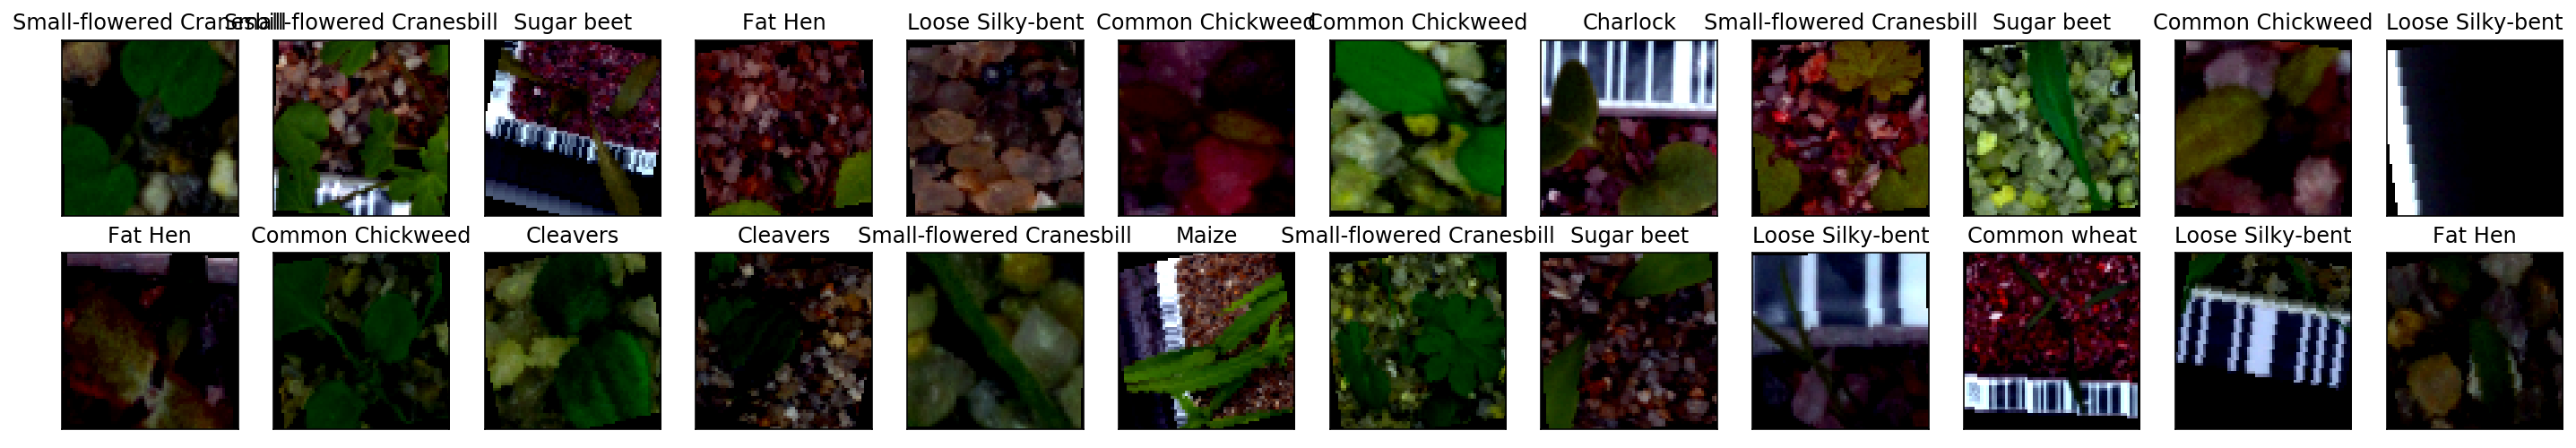

In [20]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(24):
    ax = fig.add_subplot(2, 24/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [21]:
len(classes)

12

In [22]:
images.shape

(64, 3, 64, 64)

## Define Model

In [31]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 64x64x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 32x32x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 16x16x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # conv layer 4 sees 8X8X64
        self.conv4 = nn.Conv2d(64,128,3,padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(128, 12)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        #print(x.shape)
        x = self.conv1(x)
        #print(x.shape)
        x = F.relu(x)
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        #x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        #print(x.shape)
        # flatten image input
        x = x.view(-1, 128 * 4 * 4)
        #x = x.view(x.size(0), -1)
        #print(x.shape)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        # output layer
        x = F.log_softmax(x, dim=1)
        return x
# create a complete CNN
model = Net()
print(model)
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=12, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [32]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [33]:
model(images[0:1])

tensor([[-2.4888, -2.5596, -2.4393, -2.4879, -2.4534, -2.4224, -2.4556, -2.5512,
         -2.4472, -2.5328, -2.4945, -2.4969]], grad_fn=<LogSoftmaxBackward>)

## Loss and Optimiser

In [34]:
from torch import optim
criterion = nn.NLLLoss() # Loss function Negative log likelyhood loss
optimizer = optim.Adam(model.parameters(), lr=0.01) #  learning rate 0.003

## Train Model

In [35]:
def accuracy(y_hat_tensor,label_tensor):
    '''
    args:
        y_hat_tensor tensor: direct output of the model. 
        label_tensor tensor: actual labels of the given items
    returns:
        accuracy float
        accurate float: number of accurately labeled items
        total_samples float : number of samples investigated
    '''
    y_hat_tensor = torch.exp(y_hat_tensor)
    values, pred_labels = y_hat_tensor.max(1) # works like numpy argmax plus returns the values of the cells.
    accurate = sum(1 for a, b in zip(pred_labels.numpy(), label_tensor.numpy()) if a == b)
    total_samples = len(label_tensor)
    accuracy = accurate/total_samples
    return accuracy,accurate,total_samples

In [36]:
labels

tensor([11,  1,  3,  8,  9,  1,  6,  3,  8,  3, 10,  2,  8, 10, 10,  5,  8,  6,
         5, 10,  3,  3, 11,  3,  5,  9,  3,  0,  4,  8,  5,  1,  6,  3,  3,  9,
         5,  3, 11,  2, 11,  6,  4,  8,  3, 10,  7,  9,  6,  3,  3,  1,  1, 11,
        11,  3,  9, 10,  6,  6,  6,  7, 11,  3])

In [40]:
epochs = 10
epoch = 0
valid_loss_min = np.Inf 
train_losses = []
valid_losses = []

for e in range(epochs):
    running_loss = 0
    total_accurate = 0
    total_samples = 0
    for images, labels in train_loader:
        # Training pass
        #print(images.shape)
        output = model(images) # directly passes the images into forward method
        loss = criterion(output, labels)
        optimizer.zero_grad() # clear gradients
        loss.backward() # compute gradients
        optimizer.step() # update weights
        
        batch_train_accuracy,accurate,total_sample = accuracy(output,labels)
        running_loss += loss.item()
        total_accurate += accurate
        total_samples += total_sample
        #print(total_accurate)
    else:
        with torch.no_grad():
            model.eval()
            valid_loss = 0
            total_samples_test = 0
            total_accurate_test = 0
            for images, labels in valid_loader:
                output = model(images)
                valid_loss += criterion(output, labels)
                batch_test_accuracy,accurate_test,total_sample_test = accuracy(output,labels)
                total_accurate_test += accurate_test
                total_samples_test += total_sample_test
        model.train()
        train_losses.append(running_loss/len(train_loader))
        valid_losses.append(valid_loss/len(valid_loader))
        print('''---------- epoch : {} -----------'''.format(epoch+1))
        print(''' Training Accuracy = {}  - Training Loss = {}'''.format(total_accurate/total_samples,running_loss/len(train_loader)))
        print(''' Test Accuracy = {}  - Test Loss = {}'''.format(total_accurate_test/total_samples_test,valid_loss/len(valid_loader)))
        epoch += 1
        print(valid_loss/len(valid_loader))
        print(valid_loss_min)
        if valid_loss/len(valid_loader)<valid_loss_min:
            valid_loss_min = valid_loss/len(valid_loader)
            print('validation loss decreased! Saving model..')
            torch.save(model.state_dict(), '../models/model_13.pt')
            

---------- epoch : 1 -----------
 Training Accuracy = 0.12721804511278195  - Training Loss = 2.4184655317893395
 Test Accuracy = 0.1375438596491228  - Test Loss = 2.4350948333740234
tensor(2.4351)
inf
validation loss decreased! Saving model..
---------- epoch : 2 -----------
 Training Accuracy = 0.13774436090225564  - Training Loss = 2.4145189111049357
 Test Accuracy = 0.1375438596491228  - Test Loss = 2.4349842071533203
tensor(2.4350)
tensor(2.4351)
validation loss decreased! Saving model..
---------- epoch : 3 -----------
 Training Accuracy = 0.13203007518796991  - Training Loss = 2.412973220531757
 Test Accuracy = 0.1375438596491228  - Test Loss = 2.4282195568084717
tensor(2.4282)
tensor(2.4350)
validation loss decreased! Saving model..
---------- epoch : 4 -----------
 Training Accuracy = 0.13052631578947368  - Training Loss = 2.4120282439085154
 Test Accuracy = 0.1375438596491228  - Test Loss = 2.430666446685791
tensor(2.4307)
tensor(2.4282)
---------- epoch : 5 -----------
 Train